In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
DATA_PATH = os.path.join(os.getcwd(), 'data')
TEST_DATASET_PATH = os.path.join(DATA_PATH, 'test')
TRAIN_DATASET_PATH = os.path.join(DATA_PATH, 'train')
OUTPUT_PATH = os.path.join(DATA_PATH, 'segmented_train')
SEGMENTED_TRAIN_DATASET_PATH = os.path.join(DATA_PATH, 'segmented_train')
AUGMENTED_SEGMENTED_TRAIN_DATASET_PATH = os.path.join(DATA_PATH, 'augmented_segmented_train')

In [21]:
def dilate(image, kernel_size=(3, 3)):
    kernel = np.ones(kernel_size, np.uint8)
    dilation = cv2.dilate(image, kernel, iterations=1)
    return dilation

def erode(image, kernel_size=(3, 3)):
    kernel = np.ones(kernel_size, np.uint8)
    erosion = cv2.erode(image, kernel, iterations=1)
    return erosion

def gaussian_thresholding(image, kernel=(5, 5), block_size=11, C=2):
    blur = cv2.GaussianBlur(image, kernel, 0)
    thresholded_image = cv2.adaptiveThreshold(
        blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, blockSize=block_size, C=C
    )
    return thresholded_image


def combine_boxes(box1, box2):
    """Combine two overlapping boxes into a single box."""
    x1 = min(box1[0], box2[0])
    y1 = min(box1[1], box2[1])
    x2 = max(box1[0] + box1[2], box2[0] + box2[2])
    y2 = max(box1[1] + box1[3], box2[1] + box2[3])

    # Return combined box
    return (x1, y1, x2 - x1, y2 - y1)

def boxes_overlap(box1, box2):
    """Check if two boxes overlap."""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

def non_max_suppression(boxes):
    """Combine overlapping boxes."""
    if len(boxes) == 0:
        return []

    boxes = sorted(boxes, key=lambda box: box[0])  # Sort by x-coordinate
    combined_boxes = []

    while boxes:
        current_box = boxes.pop(0)
        to_merge = []

        # Check for boxes that overlap with current_box and merge them
        for box in boxes:
            if boxes_overlap(current_box, box):  # Check if they overlap
                to_merge.append(box)

        # Combine all overlapping boxes into one
        for box in to_merge:
            current_box = combine_boxes(current_box, box)
            boxes.remove(box)

        combined_boxes.append(current_box)

    return combined_boxes

def extract_contours(image, min_height=10):
    """Extract contours and return bounding boxes."""
    inverted_image = cv2.bitwise_not(image)
    contours, _ = cv2.findContours(inverted_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract bounding boxes and filter by height
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours if cv2.boundingRect(contour)[3] > min_height]

    return bounding_boxes

def segment_characters(image):
    """Segment the CAPTCHA image into individual characters using NMS."""
    # Step 1: Extract bounding boxes from contours
    bounding_boxes = extract_contours(image)

    # Step 2: Apply Non-Maximum Suppression (NMS) to remove overlapping boxes
    # nms_boxes = non_max_suppression(bounding_boxes)
    nms_boxes = bounding_boxes

    # Step 3: Create tuples of (x_coordinate, box, char_image) to maintain correct order
    char_info = []
    for box in nms_boxes:
        x, y, w, h = box
        char_image = image[y:y+h, x:x+w]
        char_info.append((x, box, char_image))

    # Step 4: Sort by x-coordinate and extract ordered images
    char_info.sort(key=lambda x: x[0])  # Sort by x-coordinate
    nms_boxes = [info[1] for info in char_info]  # Keep boxes in same order
    char_images = [info[2] for info in char_info]  # Keep images in same order

    return nms_boxes, char_images # nms_boxes is used for plotting

def adaptive_thresholding(image):
    return cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, blockSize=11, C=2
    )

def remove_noise(image):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    cleaned_image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned_image = cv2.morphologyEx(cleaned_image, cv2.MORPH_CLOSE, kernel, iterations=1)
    return cleaned_image

def remove_lines(image):
    lines = cv2.HoughLinesP(image, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image, (x1, y1), (x2, y2), 0, thickness=2)
    return image

def preprocess_image(image):
    image = cv2.bitwise_not(image)
    image = erode(image, kernel_size=(2, 2))
    image = cv2.bitwise_not(image)
    image = gaussian_thresholding(image, kernel=(5, 5), block_size=11, C=2)
    image = erode(image, kernel_size=(2, 2))
    image = gaussian_thresholding(image, kernel=(5, 5), block_size=11, C=2)
    image = erode(image, kernel_size=(2, 2))

    # # Apply preprocessing steps
    # image = adaptive_thresholding(image)
    # image = remove_noise(image)
    # image = remove_lines(image)
    # image = cv2.bitwise_not(image)

    # image = gaussian_thresholding(image)
    # image = dilate(image)
    return image

In [22]:
def process_and_save_images(input_dir, output_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Keep track of how many captchas were skipped
    skipped_count = 0

    # Process each image in the input directory
    for filename in os.listdir(input_dir):
        if not filename.endswith('.png'):
            continue

        # Extract the true label from the filename
        base_name = filename.split('-')[0]

        # Load the image
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Apply preprocessing steps
        image = preprocess_image(image)

        # Segment characters
        _, char_images = segment_characters(image)

        # Validate the number of segmented parts
        if len(char_images) != len(base_name):
            print(f"Skipping {filename}: Expected {len(base_name)} parts, got {len(char_images)}.")
            skipped_count += 1
            continue  # Skip saving this image

        # Save each segmented character follow the naming convention <label_str>-<char>.png
        for idx, char_img in enumerate(char_images):
            char_label = base_name[idx]
            save_name = f"{base_name}-{char_label}.png"
            save_path = os.path.join(output_dir, save_name)

            # Save the segmented character
            cv2.imwrite(save_path, char_img)

    print(f"Processing complete! Segmented characters are saved in {output_dir}")
    print(f"Total skipped: {skipped_count}")

process_and_save_images(TRAIN_DATASET_PATH, SEGMENTED_TRAIN_DATASET_PATH)

Skipping 00fh-0.png: Expected 4 parts, got 0.
Skipping 010b-0.png: Expected 4 parts, got 7.
Skipping 010ud-0.png: Expected 5 parts, got 2.
Skipping 02cc-0.png: Expected 4 parts, got 2.
Skipping 057ea-0.png: Expected 5 parts, got 6.
Skipping 06rh65-0.png: Expected 6 parts, got 5.
Skipping 06w6m8y-0.png: Expected 7 parts, got 8.
Skipping 06xg-0.png: Expected 4 parts, got 6.
Skipping 06yx8nkv-0.png: Expected 8 parts, got 7.
Skipping 07smvpl-0.png: Expected 7 parts, got 9.
Skipping 08mse1o-0.png: Expected 7 parts, got 9.
Skipping 08xj75-0.png: Expected 6 parts, got 7.
Skipping 09bki-0.png: Expected 5 parts, got 6.
Skipping 0axhfa-0.png: Expected 6 parts, got 5.
Skipping 0bag6mnf-0.png: Expected 8 parts, got 9.
Skipping 0bcjvo4p-0.png: Expected 8 parts, got 10.
Skipping 0d0vp1-0.png: Expected 6 parts, got 5.
Skipping 0duo1r-0.png: Expected 6 parts, got 3.
Skipping 0dw9b7hd-0.png: Expected 8 parts, got 7.
Skipping 0fm4a3rx-0.png: Expected 8 parts, got 14.
Skipping 0hox6-0.png: Expected 5 par

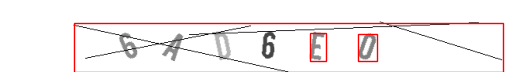

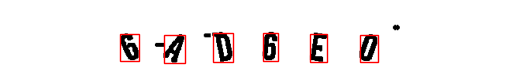

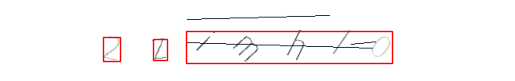

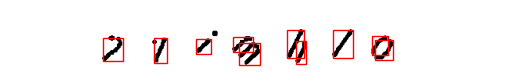

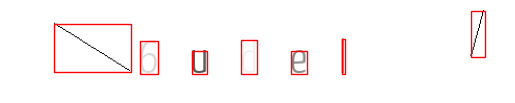

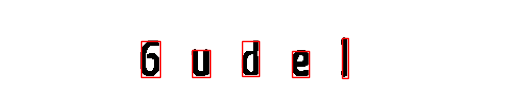

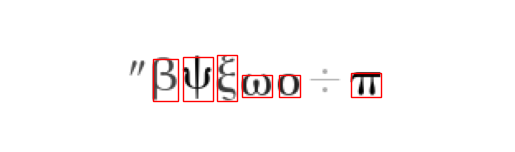

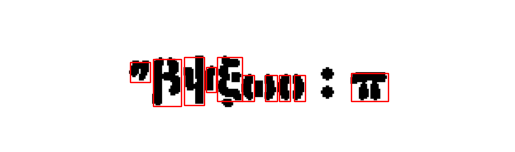

In [24]:
## plot image and bounding boxes
def plot_image(image, boxes, labels, annot=False):
    """Plot image with bounding boxes."""
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')

    for box in boxes:
        x, y, w, h = box
        rect = plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ## add label
        if annot:
            ax.text(x, y, labels[boxes.index(box)], color='r', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

samples = ['6ad6e0-0.png', '2zimhl0-0.png', '6udel-0.png', '0bcjvo4p-0.png']
for sample in samples:
    image = cv2.imread(os.path.join(TRAIN_DATASET_PATH, sample), cv2.IMREAD_GRAYSCALE)
    
    ## before preprocessing
    boxes, char_images = segment_characters(image)
    base_name = sample.split('-')[0]
    plot_image(image, boxes, base_name)

    ## after preprocessing
    image = preprocess_image(image)
    boxes, char_images = segment_characters(image)
    base_name = sample.split('-')[0]
    plot_image(image, boxes, base_name)

In [28]:
def augment_and_save_images(input_dir, output_dir, augment_count=3):
    """Augment images from `input_dir` and save them with proper naming to `output_dir`."""
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists

    # Define a more controlled data augmentation pipeline
    datagen = ImageDataGenerator(
        rotation_range=10,          # Small rotation for better quality
        width_shift_range=0.05,     # Slight horizontal shift
        height_shift_range=0.05,    # Slight vertical shift
        shear_range=0.1,            # Mild shearing
        zoom_range=0.1,             # Mild zoom
        fill_mode='nearest'         # Avoid introducing artifacts
    )

    # Loop through all images in the input directory
    for filename in os.listdir(input_dir):
        if not filename.endswith('.png'):
            continue
        
        # Load the original image
        image_path = os.path.join(input_dir, filename)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Expand dimensions for augmentation
        img = np.expand_dims(img, axis=-1)  # Add channel dimension
        img = np.expand_dims(img, axis=0)   # Add batch dimension

        # Extract the base filename without extension (e.g., 'abc-o')
        base_name = filename.split('.')[0]

        # Generate and save augmented images
        for i, batch in enumerate(datagen.flow(img, batch_size=1)):
            # Save each augmented image with proper naming
            augmented_filename = f"{base_name}-{i + 1}.png"
            augmented_path = os.path.join(output_dir, augmented_filename)

            # Save the augmented image
            cv2.imwrite(augmented_path, batch[0].squeeze().astype(np.uint8))

            # Stop after generating `augment_count` images per original image
            if i + 1 >= augment_count:
                break

    print(f"Augmentation complete! Augmented images saved in {output_dir}")


# Example usage
input_dir = SEGMENTED_TRAIN_DATASET_PATH
output_dir = AUGMENTED_SEGMENTED_TRAIN_DATASET_PATH
augment_and_save_images(input_dir, output_dir)

Augmentation complete! Augmented images saved in d:\cs4243\data\augmented_segmented_train


In [29]:
from sklearn.model_selection import train_test_split

output_dir = AUGMENTED_SEGMENTED_TRAIN_DATASET_PATH

# Define character set (e.g., 0-9, a-z)
CHAR_SET = "0123456789abcdefghijklmnopqrstuvwxyz"
CHAR_TO_IDX = {char: idx for idx, char in enumerate(CHAR_SET)}

def load_dataset(data_dir):
    images = []
    labels = []

    for filename in os.listdir(data_dir):
        if filename.endswith('.png'):
            # Extract the character from the filename (e.g., 'o' from 'oq1j-o.png')
            char_label = filename.split('-')[1][0]

            if char_label in CHAR_TO_IDX:
                # Load the image in grayscale
                image_path = os.path.join(data_dir, filename)
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                # Resize to 28x28 (if needed)
                img = cv2.resize(img, (28, 28))
                img = img / 255.0  # Normalize pixel values to [0, 1]

                # Store the image and label
                images.append(img)
                labels.append(CHAR_TO_IDX[char_label])

    # Convert to numpy arrays
    images = np.array(images).reshape(-1, 28, 28, 1)  # Add channel dimension
    labels = np.array(labels)

    return images, labels

# Load the dataset
images, labels = load_dataset(output_dir)
print(f"Loaded {len(images)} images with {len(set(labels))} unique labels.")

Loaded 112638 images with 36 unique labels.


In [34]:
# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}, Validation set size: {X_val.shape[0]}")

Training set size: 90110, Validation set size: 22528


In [ ]:
#MODEL 1 ~8%

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# def build_model(num_classes):
#     model = Sequential([
#         Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#         MaxPooling2D((2, 2)),
#         Dropout(0.2),

#         Conv2D(64, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Dropout(0.2),

#         Flatten(),
#         Dense(128, activation='relu'),
#         Dropout(0.5),
#         Dense(num_classes, activation='softmax')
#     ])

#     model.compile(optimizer='adam',
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model

# # Build the model for 36 classes (0-9, a-z)
# num_classes = len(CHAR_SET)
# model = build_model(num_classes)
# model.summary()

In [ ]:
#MODEL 2 ~24%

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, ReLU

# def build_custom_cnn(num_classes):
#     model = Sequential()

#     # First Conv Block
#     model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     # Second Conv Block
#     model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     # Third Conv Block
#     model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     # Fully Connected Layers
#     model.add(Flatten())
#     model.add(Dropout(0.5))
#     model.add(Dense(128, activation='relu'))
#     model.add(Dense(36, activation='softmax'))  # 36 classes: 0-9 + a-z

#     # Compile the model
#     model.compile(optimizer='adam',
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])

#     return model


# num_classes = len(CHAR_SET)
# model = build_model(num_classes)
# model.summary()


In [ ]:
# #MODEL 3 ~33% (AlexNet)

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU

# def build_alexnet():
#     model = Sequential()

#     # 1st Convolutional Layer
#     model.add(Conv2D(64, (3, 3), strides=1, padding='same', input_shape=(28, 28, 1)))
#     model.add(BatchNormalization())
#     model.add(ReLU())
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     # 2nd Convolutional Layer
#     model.add(Conv2D(128, (3, 3), strides=1, padding='same'))
#     model.add(BatchNormalization())
#     model.add(ReLU())
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     # 3rd Convolutional Layer
#     model.add(Conv2D(256, (3, 3), strides=1, padding='same'))
#     model.add(BatchNormalization())
#     model.add(ReLU())
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     # Flatten the output for Fully Connected Layers
#     model.add(Flatten())

#     # 1st Fully Connected Layer
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.5))

#     # 2nd Fully Connected Layer
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.5))

#     # Output Layer
#     model.add(Dense(36, activation='softmax'))

#     model.compile(optimizer='adam',
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])

#     return model

# model = build_alexnet()
# model.summary()

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_crnn_model(input_shape=(28, 28, 1), num_classes=36, dropout_rate=0.5):
    inputs = layers.Input(shape=input_shape)

    # Convolutional layers
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)

    # Adding a Dropout layer after convolutional layers
    x = layers.Dropout(dropout_rate)(x)

    # Calculate the new shape
    height = x.shape[1]  # height after convolution and pooling
    width = x.shape[2]   # width after convolution and pooling
    channels = x.shape[3]  # channels after convolution
    new_shape = (height, width * channels)  # Reshape to (time_steps, features)

    # Reshape for LSTM input
    x = layers.Reshape(target_shape=new_shape)(x)

    # Recurrent layers
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(dropout_rate)(x)  # Adding dropout after the first LSTM

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)
    x = layers.Dropout(dropout_rate)(x)  # Adding dropout after the second LSTM

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Build the CRNN model
model = build_crnn_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 896)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 7, 256)         │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,545,764 (5.90 MB)

 Trainable params: 1,545,764 (5.90 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3
)

# Train the model with EarlyStopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 99s 66ms/step - accuracy: 0.4320 - loss: 2.0225 - val_accuracy: 0.7462 - val_loss: 0.8647 - learning_rate: 0.0010
Epoch 2/100
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 94s 66ms/step - accuracy: 0.7287 - loss: 0.9199 - val_accuracy: 0.7769 - val_loss: 0.7430 - learning_rate: 0.0010
Epoch 3/100
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 92s 65ms/step - accuracy: 0.7662 - loss: 0.7891 - val_accuracy: 0.7984 - val_loss: 0.6736 - learning_rate: 0.0010
Epoch 4/100
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 92s 65ms/step - accuracy: 0.7859 - loss: 0.7067 - val_accuracy: 0.8037 - val_loss: 0.6521 - learning_rate: 0.0010
Epoch 5/100
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 93s 66ms/step - accuracy: 0.8021 - loss: 0.6535 - val_accuracy: 0.8150 - val_loss: 0.6087 - learning_rate: 0.0010
Epoch 6/100
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 93s 66ms/step - accuracy: 0.8126 - loss: 0.6078 - val_accuracy: 0.8241 - val_loss: 0.5830 - learning_rate: 0.0010
Epoch 7/100
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 92s 65ms/step -

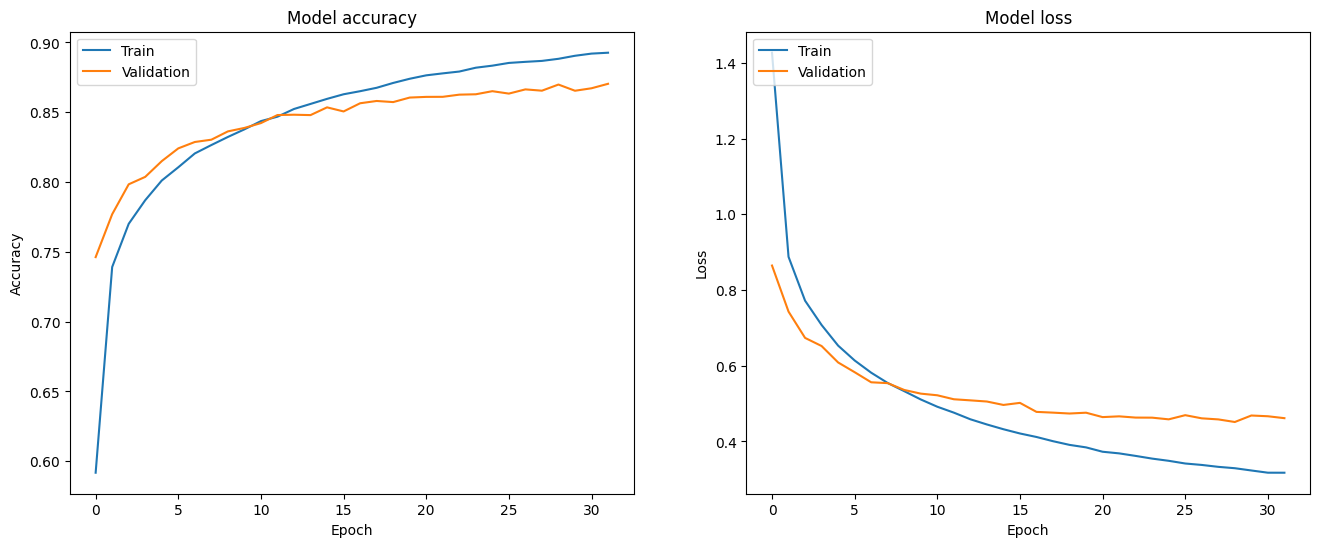

In [44]:
# Convert to a DataFrame
import pandas as pd
history_df = pd.DataFrame(history.history)

# Visualize the History

import matplotlib.pyplot as plt

def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot training & validation accuracy values
    axes[0].plot(history['accuracy'])
    axes[0].plot(history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    axes[1].plot(history['loss'])
    axes[1].plot(history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_history(history_df)

In [45]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8715 - loss: 0.4509
Validation Accuracy: 86.99%


In [40]:
# Save the trained model
def save_model(model, dir_path, model_name="character_recognition_model.h5"):
    # Ensure the directory exists
    os.makedirs(dir_path, exist_ok=True)

    # Create the full path to the model file
    model_path = os.path.join(dir_path, model_name)

    # Save the model
    model.save(model_path)
    print(f"Model saved successfully at: {model_path}")

# Example usage
save_dir = os.path.join(DATA_PATH, 'models')
save_model(model, save_dir, 'crnn_89.keras')

Model saved successfully at: d:\cs4243\data\models\crnn_89.keras


In [49]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
MODEL_PATH = os.path.join(DATA_PATH, 'models', 'crnn_89.keras')
model = load_model(MODEL_PATH)

# Define the character set used during training
CHAR_SET = "0123456789abcdefghijklmnopqrstuvwxyz"
CHAR_MAP = {idx: char for idx, char in enumerate(CHAR_SET)}


def predict_character(image, model):
    """Predict a single character using the trained model."""
    img = cv2.resize(image, (28, 28)) / 255.0  # Resize and normalize
    img = np.expand_dims(img, axis=[0, -1])  # Add batch and channel dimensions

    prediction = model.predict(img)
    predicted_label = np.argmax(prediction)
    predicted_char = CHAR_MAP[predicted_label]
    return predicted_char

def predict_captcha_string(image_path, model):
    """Predict the entire CAPTCHA string from the input image."""
    # Load the image
    image_path = os.path.join(input_dir, image_path)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Preprocess the image
    processed_image = preprocess_image(image)

    # Segment the characters
    _, char_images = segment_characters(processed_image)

    # Predict each character and reconstruct the string
    predicted_string = ""
    for char_img in char_images:
        predicted_char = predict_character(char_img, model)
        predicted_string += predicted_char

    return predicted_string

# Example usage
captcha_image_path = os.path.join(TEST_DATASET_PATH, "2d76-0.png")
predicted_string = predict_captcha_string(captcha_image_path, model)
print(f"Predicted CAPTCHA string: {predicted_string}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted CAPTCHA string: 2d76


In [51]:
import os

def evaluate_on_unseen_data(unseen_dir, model, num_images=20):
    """Evaluate the model on the first `num_images` from the unseen directory."""
    correct_predictions = 0
    total_images = 0

    # Get the first `num_images` files from the directory
    all_files = np.array([f for f in os.listdir(unseen_dir) if f.endswith('.png')])

    # Shuffle the files
    np.random.seed(42)
    np.random.shuffle(all_files)
    all_files = all_files[:num_images]

    for filename in all_files:
        # Extract the true label from the filename (e.g., '2d76' from '2d76-0.png')
        true_label = filename.split('-')[0]

        # Get the full path to the image
        image_path = os.path.join(unseen_dir, filename)

        # Predict the CAPTCHA string
        predicted_string = predict_captcha_string(image_path, model)
        print(f"True: {true_label}, Predicted: {predicted_string}")

        # Compare the predicted string with the true label
        if predicted_string == true_label:
            correct_predictions += 1

        total_images += 1

    # Calculate accuracy
    accuracy = correct_predictions / total_images * 100
    print(f"\nAccuracy on the first {num_images} images: {accuracy:.2f}%")

# Example usage
unseen_dir = TEST_DATASET_PATH
evaluate_on_unseen_data(unseen_dir, model, 1000)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
True: x2xk02p, Predicted: x2xk02p
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
True: 63zdn, Predicted: 63zdn
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
True: ns45, Predicted: mg5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
True: ghdb, Predicted: ghdb
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━

In [69]:
from tensorflow import keras

# Load your model
MODEL_PATH = os.path.join(DATA_PATH, 'models', 'crnn_89.keras')
model = keras.models.load_model(MODEL_PATH)

In [70]:
# Extract the embedding layer output
embedding_layer = model.get_layer('dense')  # or specify the index if unnamed
embeddings = embedding_layer.weights[0]  # The weights of the embedding layer

In [71]:
# Step 2: Create an embedding model 
embedding_model = Model(inputs=model.input, outputs=model.layers[-2].output) 

In [79]:
# Step 3: Get embeddings by running sample data through the embedding model
n_samples = 10000
embeddings = embedding_model.predict(X_train[:n_samples])

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [82]:
# Step 4: Prepare metadata
LOGS_DIR = os.path.join(os.getcwd(), 'logs')

labels = y_train[:n_samples]
labels = [CHAR_MAP[label] for label in labels]

with open(os.path.join(LOGS_DIR, "metadata.tsv"), "w") as f:
    for label in labels:
        f.write(f"{label}\n")

# Step 5: Save embeddings as .tsv
np.savetxt(os.path.join(LOGS_DIR, "embeddings.tsv"), embeddings, delimiter="\t")

In [83]:
# Step 6: Set up TensorBoard logging
log_dir = os.path.join(LOGS_DIR, "embedding_projector")
with tf.summary.create_file_writer(log_dir).as_default():
    tf.summary.text("embedding_metadata", os.path.join(LOGS_DIR, "metadata.tsv"), step=0)
    tf.summary.text("embedding_vectors", os.path.join(LOGS_DIR, "embeddings.tsv"), step=0)